In [105]:
# data wraggling functions 
import pandas as pd
import numpy as np
from langdetect import detect
import time

# EDA
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
from matplotlib.pyplot import figure
import seaborn as sns

# NLP preprocessing functions
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

# train test split
from sklearn.model_selection import train_test_split

# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
from scipy.sparse import hstack

# modeling functions
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ElasticNet, Lasso # sparse models
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge # regularization properties
from sklearn.kernel_ridge import KernelRidge #

# model testing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

import pickle

## Load in the merged data

In [55]:
project_data_from_sql = pickle.load(open("pickle/project_data_complete.pkl", "rb"))
project_data_from_sql.shape

(2206, 27)

## Filter out non-english entries and ones without a story

In [3]:
# make function to handle exceptions:
def trydetect(s):
    try:
        r = detect(s)
    except:
        r = "NA"
    return r

In [70]:
# detect the language of the blurb
project_data_from_sql['language'] = project_data_from_sql.apply(lambda x: trydetect(x['blurb']), axis=1)
# decide if a proposals really has a story section, some had them in pictures thus not in my data
project_data_from_sql['keep_story'] = project_data_from_sql.apply(lambda x: 
                                                                  len(x['story']) > len(x['blurb']), axis=1)

In [72]:
# filter out non-english entries and entries without much stories
data_project = project_data_from_sql[(project_data_from_sql.keep_story == 1) & 
                                     (project_data_from_sql.language == "en")].reset_index()
data_project.shape

(2108, 30)

## Add text length features for title and blurb

In [73]:
# word count and length in title and blurb
data_project['title_words'] = data_project['project_name'].str.split().str.len()
data_project['title_l'] = data_project['project_name'].str.len()
data_project['blurb_words'] = data_project['blurb'].str.split().str.len()
data_project['blurb_l'] = data_project['blurb'].str.len()

## Preprocess text information

In [8]:
# define function to lemmatize long-form text
def lemmatizer(sentence):
    token_words = word_tokenize(sentence)
    lem_sentence=[]
    for word in token_words:
        lemma = wnl.lemmatize(word)
        lem_sentence.append(lemma)
        lem_sentence.append(" ")
    return "".join(lem_sentence)

# make preprocessing pipeline:
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def preproc(text):
    l = re.sub(r'http\S+',' ', text) # remove links
    n = re.sub(r'[0-9]+', ' ', l) # remove numbers
    s = re.sub(r'[^\w]',' ', n)  # remove symbols
    w = pattern.sub('', s) # remove stopwords
    p = lemmatizer(w) # lemmatize all words
    return p

In [74]:
# combine the apply the preprocessing pipeline to all available data
data_project['story_tb'] = data_project["project_name"].map(str) + data_project["blurb"].map(str) +data_project["story"].map(str)
data_project['story_p'] = data_project.apply(lambda x: preproc(x['story_tb']), axis=1)
# add total text length
data_project['total_words'] = data_project['story_p'].str.split().str.len()

## EDA on response variables

In [75]:
# check the balance between projects that succeed vs fail
data_project['state_b'] = data_project.apply(lambda x: x['state'] == 'successful', axis=1)
data_project['state_b'].sum()/len(data_project['state_b'])
# the data is quite balanced

0.5412713472485768

In [76]:
# add log-transformed version of some variables that are highly skewed

data_project['l_goal'] = np.log10(data_project['goal_usd'] + 1)
data_project['l_pledge'] = np.log10(data_project['pledge_usd'] + 1)
data_project['l_percent'] = np.log10(data_project['percent']*100+1)
data_project['l_backers'] = np.log10(data_project['backers']+ 1)

<function matplotlib.pyplot.show(*args, **kw)>

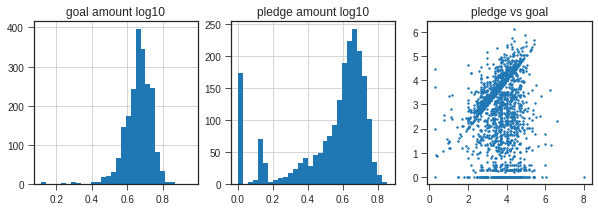

In [20]:
# look at the distribution of goal and pledg amounts
plt.figure(figsize=(10,3))

plt.subplot(1, 3, 1)
np.log10(data_project['l_goal'] + 1).hist(bins = 30)
plt.title('goal amount log10')

plt.subplot(1, 3, 2)
np.log10(data_project['l_pledge'] + 1).hist(bins = 30)
plt.title('pledge amount log10')

plt.subplot(1, 3, 3)
plt.scatter(data_project['l_goal'], data_project['l_pledge'], s = 2)
plt.title('pledge vs goal')

plt.show
# both variables are fairly normally distributed after log transformation
# there are three distinct groups of projects: no pledge, some pledge, success

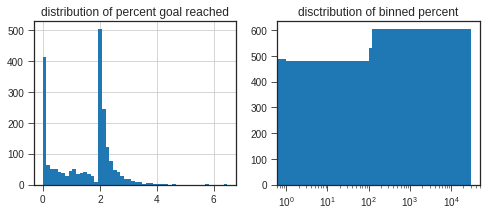

In [21]:
plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
np.log10(data_project['percent']*100+1).hist(bins = 50)
plt.title('distribution of percent goal reached')

plt.subplot(1, 2, 2)
plt.hist(data_project['percent']*100, bins = [0, 1, 100, 120, 30000])
plt.xscale('log')
plt.title('disctribution of binned percent')

plt.show()
# again large numbers of projects raise almost no money or about what they ask for
# in light of this and the previous figure, 
# I will engineer categories that contain projects that:
# raise almost none, some, 100%, and better than expected

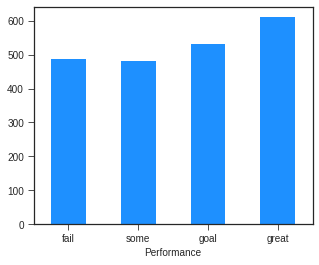

In [77]:
# based on the figures, engineered categories that contain projects that:
# raise almost none, some, 100%, and better than expected
max_bin = max(data_project['percent']*100)+1
data_project['performance'] = pd.cut(data_project['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = ["fail", "some", "goal", "great"],
                                 right = False)
data_project['performance_n'] = pd.cut(data_project['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = [0,1,2,3],
                                 right = False)
# plot the distribution of the engineered feature:
data_project[['index','performance']].groupby('performance').count().plot.bar(legend = False, 
                                                                              figsize = (5,4), 
                                                                              rot=0,
                                                                             color = 'dodgerblue')
plt.xlabel("Performance")
plt.show()
# the categores are pretty even

## EDA on predictor variables

In [24]:
data_project.groupby('performance').mean()
# longer title and total length are important
# blurb length is not

,index,project_id,project_id,goal,pledge,deadline,create,launch,staff_pick,backers,...,title_words,title_l,blurb_words,blurb_l,total_words,state_b,l_goal,l_pledge,l_percent,l_backers
performance,,,,,,,,,,,,,,,,,,,,,
fail,1177.235656,1.050628e+09,1.050628e+09,272111.389344,50.423258,1.467783e+09,1.461738e+09,1.464615e+09,0.002049,1.528689,...,4.997951,31.057377,18.885246,111.303279,211.323770,0.0,4.079994,0.739659,0.048871,0.303922
some,1178.108559,1.057407e+09,1.057407e+09,39671.601253,4306.663862,1.470342e+09,1.463211e+09,1.467347e+09,0.062630,27.450939,...,5.845511,35.743215,18.876827,112.457203,312.463466,0.0,3.787484,2.733764,1.021832,1.115506
goal,1037.562030,1.057030e+09,1.057030e+09,12849.736842,13761.047387,1.469310e+09,1.462616e+09,1.466537e+09,0.172932,105.686090,...,5.746241,34.575188,18.665414,110.481203,369.526316,1.0,3.628372,3.655300,2.031010,1.774201
great,1035.769357,1.101554e+09,1.101554e+09,10750.578254,44684.329786,1.495154e+09,1.488438e+09,1.492599e+09,0.168040,307.581549,...,6.431631,38.948929,17.881384,107.591433,439.574959,1.0,3.286172,3.731723,2.450921,2.025629


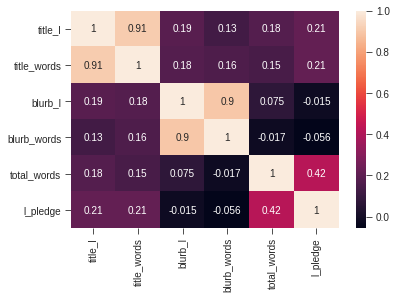

In [25]:
# check the correlations among the length features:
corr = data_project[['title_l', 'title_words','blurb_l', 'blurb_words', 'total_words', "l_pledge"]].corr()
ax = sns.heatmap(corr, annot = True)
# really high correlation within categories, especially total words and total_l
# thus will only use total_words and title_length

<function matplotlib.pyplot.show(*args, **kw)>

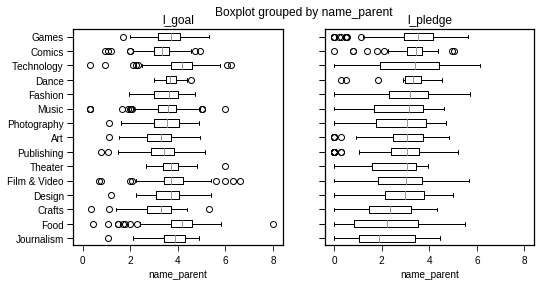

In [39]:
# plot the effects of categories on both goal and pledge amounts
category_list = data_project[['name_parent','l_pledge']].\
  groupby(['name_parent']).median().sort_values('l_pledge').index

cat_type = pd.CategoricalDtype(categories=category_list, ordered=True)

data_category_pledge = data_project[['name_parent','l_goal','l_pledge']].astype({'name_parent': cat_type})
#data_category_pledge['cat'] = data_category_pledge['name_parent'].astype(cat_type)

plt.style.use('grayscale')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
data_category_pledge.boxplot(column = ['l_goal', 'l_pledge'],
                             by = 'name_parent',
                             grid = False,
                             return_type = 'dict',
                             vert=False,
                             boxprops= dict(linewidth=1.0, color='black'),
                             figsize=(8,4))
plt.tick_params(axis='x', colors='black')
plt.show

# variation in both goal and pledge amounts across categories

# Train-test-validation split

In [91]:
data_project_c = data_project.sample(frac=1, random_state = 89).reset_index(drop=True)
data_y = data_project_c[['performance', 'performance_n', 'state_b', 'l_pledge']]
data_x = data_project_c[['name_parent', 'goal_usd', 'story_p', 'title_l', 'total_words']]
# name_parent is the name of the main category

X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size = 0.20, random_state = 61, stratify = data_x[['name_parent']])

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 59, stratify = X_train[['name_parent']])

## Tf-idf

In [92]:
tfidf = TfidfVectorizer()
# note the default normalizes the output matrix
tfidf_m = tfidf.fit_transform(x_train['story_p'])
tfidf_val = tfidf.transform(x_val['story_p'])

tfidf_m.shape

(1348, 38509)

## Combine all project information

In [93]:
# add category information
encoder = onehot.fit_transform(x_train[['name_parent']])
encoded_val = onehot.transform(x_val[['name_parent']])

# combine different feature data
x_train_info = x_train[['goal_usd', 'title_l', 'total_words']]
x_train_sparse = hstack([tfidf_m, encoder]).toarray()
x_train_full = np.concatenate((x_train_info, x_train_sparse), axis= 1)

x_val_info = x_val[['goal_usd', 'title_l', 'total_words']]
x_val_sparse = hstack([tfidf_val, encoded_val]).toarray()
x_val_full = np.concatenate((x_val_info, x_val_sparse), axis= 1)

# Test different models

In [86]:
# make function to display r2 and mse easily:
def display_score(y_true, y_predict):
    print("r2:",round(r2_score(y_true,y_predict), 3),
          "mse:",round(mean_squared_error(y_true,y_predict), 3))

In [ ]:
# this is my baseline model
r_gcr = GaussianProcessRegressor()
r_gcr.fit(x_train_full, y_train['l_pledge'])
r_gcr_predict = r_gcr.predict(x_val_full)
display_score(y_val['l_pledge'], r_gcr_predict)
# Gaussian Process does worse than random

In [108]:
r_ls = Lasso()
r_ls.fit(x_train_full, y_train['l_pledge'])
r_ls_predict = r_ls.predict(x_val_full)
display_score(y_val['l_pledge'], r_ls_predict) 
# performs ok

0.217 1.573


In [109]:
# elastic net model for sparse model with regularization
r_en = ElasticNet()
r_en.fit(x_train_full, y_train['l_pledge'])
r_en_predict = r_en.predict(x_val_full)
display_score(y_val['l_pledge'], r_en_predict) 
# performs similarly to lasso

0.219 1.568


In [ ]:
r_svr = LinearSVR()
r_svr.fit(x_train_full, y_train['l_pledge'])
r_svr_predict = r_svr.predict(x_val_full)
display_score(y_val['l_pledge'], r_svr_predict) 
# failed to converge

In [94]:
# ridge model
ridge = Ridge()
ridge.fit(x_train_full, y_train['l_pledge'])
ridge_predict = ridge.predict(x_val_full)
display_score(y_val['l_pledge'], ridge_predict) 
# performs okay:

r2: 0.373 mse: 1.271


/home/sheng/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.17728e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


In [97]:
r_kridge = KernelRidge()
r_kridge.fit(x_train_full, y_train['l_pledge'])
r_kridge_predict = r_kridge.predict(x_val_full)
display_score(y_val['l_pledge'], r_kridge_predict) 
# performs similarly to ridge, maybe a little bit worse

/home/sheng/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.90971e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


r2: 0.363 mse: 1.29


## Dive more into the ridge model:

## feature selection

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# make pipeline
pipe_fs = Pipeline([('fs', SelectKBest(chi2, k = 2000)), ('ridge', Ridge())])

# train model
pipe_fs.fit(x_train_full, y_train['l_pledge'].astype('int'))

# test model performance
pipe_fs_predict = pipe_fs.predict(x_val_full)
display_score(y_val['l_pledge'], pipe_fs_predict) 

# feature selection doesn't do a good job selecting the useful features

r2: 0.205 mse: 1.562


## Reduce feature number throgh tf-idf

In [98]:
tfidf_r = TfidfVectorizer(max_features = 1500)
# note the default normalizes the output matrix
tfidf_m_r = tfidf_r.fit_transform(x_train['story_p'])
tfidf_val_r = tfidf_r.transform(x_val['story_p'])

x_train_info = x_train[['title_l', 'total_words']]
x_train_sparse_r = hstack([tfidf_m_r, encoder]).toarray()
x_train_full_r = np.concatenate((x_train_sparse_r, x_train_info), axis= 1)

x_val_info = x_val[['title_l', 'total_words']]
x_val_sparse_r = hstack([tfidf_val_r, encoded_val]).toarray()
x_val_full_r = np.concatenate((x_val_sparse_r, x_val_info), axis= 1)

ridge_r = Ridge()
ridge_r.fit(x_train_full_r, y_train['l_pledge'])
ridge_r_predict = ridge_r.predict(x_val_full_r)
display_score(y_val['l_pledge'], ridge_r_predict) 

r2: 0.369 mse: 1.277


## Tuning the regularization term

In [100]:
ridge_a = Ridge(alpha = 0.8)
ridge_a.fit(x_train_full_r, y_train['l_pledge'])
ridge_a_predict = ridge_a.predict(x_val_full_r)
display_score(y_val['l_pledge'], ridge_a_predict) 
# reducing alpha value does not improve model performance
# r2: 0.349 mse: 1.308

r2: 0.361 mse: 1.294


## Try bagging

In [91]:
from sklearn.ensemble import BaggingRegressor
regr = BaggingRegressor(base_estimator = Ridge(), n_estimators=10).fit(x_train_full_r, y_train['l_pledge'])
regr_predict = regr.predict(x_val_full_r)
print(r2_score(y_val['l_pledge'], regr_predict ), mean_squared_error(y_val['l_pledge'], regr_predict ))
# bagging did not improve model performance: 0.3675219898705723 1.2599573398166986

0.4485397312060436 1.1482115164341817


## Try modeling whether a project fails completely and pledge together

In [115]:
rm_ridge = Ridge()
rm_ridge.fit(x_train_full_r, y_train[['state_b','l_pledge']])
rm_ridge_predict = rm_ridge.predict(x_val_full_r)
print(r2_score(y_val[['state_b', 'l_pledge']], rm_ridge_predict ), 
      mean_squared_error(y_val[['state_b', 'l_pledge']], rm_ridge_predict ))

/home/sheng/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.09669e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


## Try adding LDA categories

In [54]:
import gensim
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
processed_docs = x_train['story_p'].map(preprocess)
processed_docs[:10]

473     [mijn, cijfer, inzicht, mijn, cijfer, inzicht,...
307     [thinkin, real, hard, original, song, recordin...
2046    [reboot, annual, arts, festivalour, annual, pe...
1086    [aedran, apparel, aedran, apparel, brand, spec...
16      [seaside, eddy, getting, wheel, road, ellis, t...
1279    [funding, boomboxx, releasewe, releasing, boom...
388     [chef, corner, magazine, print, issue, publish...
1625    [catbeard, pirate, book, five, poopdecks, pawp...
1639    [maternity, shorts, active, womenlook, great, ...
1971    [rate, rate, reviewsocial, network, rate, peop...
Name: story_p, dtype: object

In [63]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore

dictionary = gensim.corpora.Dictionary(processed_docs)

# Create a corpus from a list of texts
lda_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train the model on the corpus.
lda_model = LdaMulticore(lda_corpus, num_topics=20, id2word=dictionary, passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
# no clear topics, I think the category information is more informative

## Try using bigrams

In [76]:
tfidf_b = TfidfVectorizer(max_features = 1500, ngram_range = (2,2))
# note the default normalizes the output matrix
tfidf_m_b = tfidf_b.fit_transform(x_train['story_p'])
tfidf_val_b = tfidf_b.transform(x_val['story_p'])

x_train_info = x_train[['title_l', 'total_words']]
x_train_sparse_br = hstack([tfidf_m_b, encoder]).toarray()
x_train_full_br = np.concatenate((x_train_sparse_br, x_train_info), axis= 1)

x_val_info = x_val[['title_l', 'total_words']]
x_val_sparse_br = hstack([tfidf_val_b, encoded_val]).toarray()
x_val_full_br = np.concatenate((x_val_sparse_br, x_val_info), axis= 1)

ridge_br = Ridge()
ridge_br.fit(x_train_full_br, y_train['l_pledge'])
ridge_br_predict = ridge_br.predict(x_val_full_br)
display_score(y_val['l_pledge'], ridge_br_predict) 
# using bigram reduces model performance:

r2: 0.256 mse: 1.46


# Test model performance using the test set

In [107]:
# use the train test datasets

tfidf_tt = TfidfVectorizer(max_features = 1500)
# note the default normalizes the output matrix
tfidf_train = tfidf_r.fit_transform(X_train['story_p'])
tfidf_test = tfidf_r.transform(X_test['story_p'])

encoder_train = onehot.fit_transform(X_train[['name_parent']])
encoded_test = onehot.transform(X_test[['name_parent']])

X_train_info = X_train[['title_l', 'total_words']]
X_train_sparse = hstack([tfidf_train, encoder_train]).toarray()
X_train_full = np.concatenate((X_train_sparse, X_train_info), axis= 1)

X_test_info = X_test[['title_l', 'total_words']]
X_test_sparse = hstack([tfidf_test, encoded_test]).toarray()
X_test_full = np.concatenate((X_test_sparse, X_test_info), axis= 1)

ridge_tt = Ridge()
ridge_tt.fit(X_train_full, Y_train['l_pledge'])
ridge_tt_predict = ridge_tt.predict(X_test_full)
display_score(Y_test['l_pledge'], ridge_tt_predict) 
# performs well

r2: 0.39 mse: 1.292


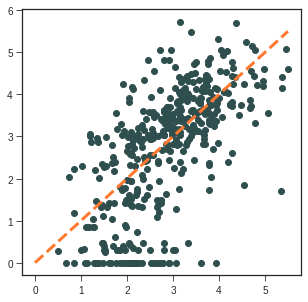

In [109]:
figure(figsize=(5,4.9))
plt.scatter(ridge_tt_predict, Y_test['l_pledge'], color = 'darkslategrey')
plt.plot( [0,5.5],[0,5.5], color = (1,0.471,0.184), linestyle = '--', linewidth=3)

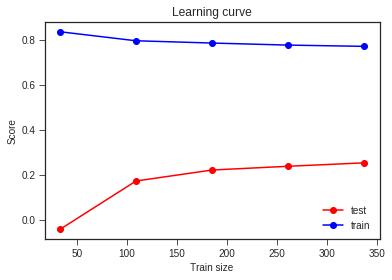

In [111]:
# learning curve for the final test
train_sizes, train_scores, test_scores = \
    learning_curve(ridge_tt, X_test_full, Y_test['l_pledge'])

plt.figure()

plt.plot(train_sizes, test_scores.mean(1), 'o-', color="r",
         label="test")
plt.plot(train_sizes, train_scores.mean(1), 'o-', color="b",
         label="train")
plt.xlabel("Train size")
plt.ylabel("Score")
plt.title('Learning curve')
plt.legend(loc="best")

plt.show()

# more data would be improve model performance

# Production model

In [112]:
# train on full dataset
tfidf_f = TfidfVectorizer(max_features = 1500)
tfidf_final = tfidf_f.fit_transform(data_x['story_p'])

encoder_final = onehot.fit_transform(data_x[['name_parent']])

X_info = data_x[['title_l', 'total_words']]
X_sparse = hstack([tfidf_final, encoder_final]).toarray()
X_full = np.concatenate((X_sparse, X_info), axis= 1)

ridge_final = Ridge()
ridge_final.fit(X_full, data_y['l_pledge'])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [113]:
# Get the feature importance of the words:
result_features = pd.DataFrame({'feature' : tfidf_f.get_feature_names(), 'importance': ridge_final.coef_[:1500]})
sorted_features = result_features.sort_values(axis = 'index', by = ['importance'])
resutls_bad_words = sorted_features.head(50)
resutls_good_words = result_features.sort_values(axis = 'index', by = ['importance'], ascending = False).head(50)

<function matplotlib.pyplot.show(*args, **kw)>

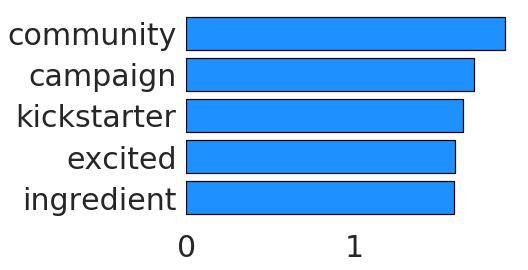

In [122]:
n_show = 5

plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Verdana'
plt.barh(range(n_show), sorted_features.iloc[-n_show:]['importance'], 
         color = "dodgerblue", edgecolor = "black", linewidth = 1.2)
plt.yticks(range(n_show), sorted_features.iloc[-n_show:]['feature'])
plt.tick_params(color = "white")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

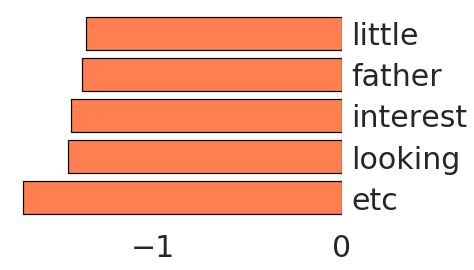

In [124]:
plt.barh(range(n_show), sorted_features.iloc[:n_show]['importance'], 
         color = "coral", edgecolor = "black", linewidth = 1.2)
plt.yticks(range(n_show), sorted_features.iloc[:n_show]['feature'])
plt.tick_params(color = "white")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show

# save things for the app:

In [117]:
with open("pickle/appv3models.pkl", "wb") as f:
    pickle.dump([ridge_final, tfidf_f, onehot, resutls_good_words, resutls_bad_words, result_features], f)